# Статистический анализ данных #

**Описание:** Анализ проводится по данным о пользователях и их поездках на самокатах из нескольких городов, которые пользуются сервисом GoFast с помощью мобильного приложения.


Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:
- без подписки:

абонентская плата отсутствует;

стоимость одной минуты поездки — 8 рублей;

стоимость старта (начала поездки) — 50 рублей;

- с подпиской Ultra:

абонентская плата — 199 рублей в месяц;

стоимость одной минуты поездки — 6 рублей;

стоимость старта — бесплатно.

**Цель:** Проанализировать данные о пользователях сервиса аренды самокатов GoFast, их поездках и подписках для выявления закономерностей и гипотез, которые могут помочь бизнесу расти.

**Ход исследования:**

1. Загрузка и предобработка данных
2. Исследовательский анализ данных
3. Объединение данных
4. Подсчет выручки
5. Проверка гипотез
6. Распределения
7. Общий вывод

In [1]:
# импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from scipy import stats as st
from math import sqrt
from scipy.stats import binom, norm

### Загрузка и предобработка данных

In [2]:
# cчитывание данных csv-файла и сохранение в переменные
try:
    users = pd.read_csv('/datasets/users_go.csv', sep=',')
    rides = pd.read_csv('/datasets/rides_go.csv', sep=',')
    subscriptions = pd.read_csv('/datasets/subscriptions_go.csv', sep=',')
except FileNotFoundError:
    print("файлы не найдены")    

Смотрим первые строки и общую информацию каждой таблицы:

In [3]:
# создадим функцию для получения общих характеристик

def all_info (data):
    print('ПЕРВЫЕ СТРОКИ')
    display(data.head(10))
    print('ОБЩАЯ ИНФОРМАЦИЯ')
    display(data.info())
    print('КОЛИЧЕСТВО ПРОПУЩЕННЫХ ЗНАЧЕНИЙ')
    display(data.isna().sum())
    print('НАЛИЧИЕ ДУБЛИКАТОВ')
    display(data.duplicated().sum())

In [4]:
all_info(users)

ПЕРВЫЕ СТРОКИ


,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
5,6,Регина,25,Краснодар,ultra
6,7,Игорь,23,Омск,ultra
7,8,Юрий,23,Краснодар,ultra
8,9,Ян,21,Пятигорск,ultra
9,10,Валерий,18,Екатеринбург,ultra


ОБЩАЯ ИНФОРМАЦИЯ
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


None

КОЛИЧЕСТВО ПРОПУЩЕННЫХ ЗНАЧЕНИЙ


user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

НАЛИЧИЕ ДУБЛИКАТОВ


31

In [5]:
all_info(rides)

ПЕРВЫЕ СТРОКИ


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
5,1,2770.890808,16.650138,2021-10-09
6,1,3039.020292,14.927879,2021-10-19
7,1,2842.118050,23.117468,2021-11-06
8,1,3412.690668,15.238072,2021-11-14
9,1,748.690645,15.041884,2021-11-22


ОБЩАЯ ИНФОРМАЦИЯ
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


None

КОЛИЧЕСТВО ПРОПУЩЕННЫХ ЗНАЧЕНИЙ


user_id     0
distance    0
duration    0
date        0
dtype: int64

НАЛИЧИЕ ДУБЛИКАТОВ


0

In [6]:
all_info(subscriptions)

ПЕРВЫЕ СТРОКИ


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


ОБЩАЯ ИНФОРМАЦИЯ
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


None

КОЛИЧЕСТВО ПРОПУЩЕННЫХ ЗНАЧЕНИЙ


subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

НАЛИЧИЕ ДУБЛИКАТОВ


0

In [7]:
# в столбце 'date' датафрейма rides изменим тип данных на datetime
rides['date'] = pd.to_datetime(rides['date'], format='%Y.%m.%d')

In [8]:
# округлим значения в столбце 'distance'
rides['distance'] = rides['distance'].round(2)

In [9]:
# удалим дубликаты 
users.drop_duplicates(inplace=True)

**Вывод:** В ходе предобработки данных таблиц пропущенные значения не выявлены, для проведения более коректного анализа изменен тип данных в столбце 'date' и округлены значения в столбце 'distance' датафрейма rides, удалены дубликаты в датафрейме users.

### Исследовательский анализ данных

#### Частота встречаемости городов

In [10]:
# сгруппируем данные по названиям городов и отсортируем по убыванию
users['city'].value_counts().sort_values(ascending=False)

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

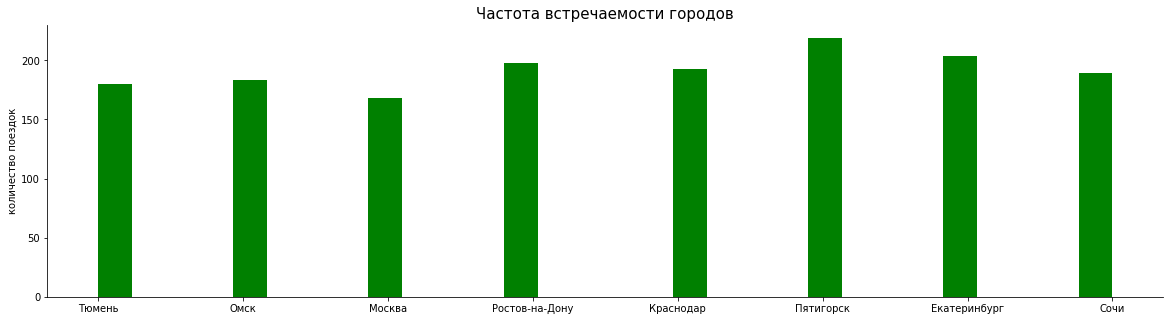

In [11]:
# строим гистограмму
users['city'].hist(bins=30, color='green', figsize=(20,5))

# установка заголовка графика
plt.title('Частота встречаемости городов', fontsize=15)

# добавление подписи оси у
plt.ylabel('количество поездок')

# уберем рамку
for pos in ['right', 'top']: 
    plt.gca().spines[pos].set_visible(False)

# убираем сетку
plt.grid(False)

# показ гистограммы
plt.show()

По полученным данным видно, что чаще всего сервисом GoFast пользуются жители города Пятигорск, меньше всего пользуются сервисом в Москве.

#### Соотношение пользователей с подпиской и без подписки

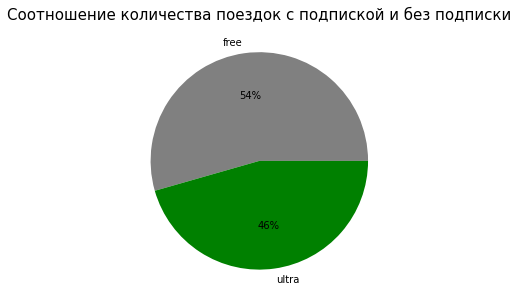

In [12]:
# строим диаграмму
users['subscription_type'].value_counts().plot(kind = 'pie', figsize = (5,5), colors = ['gray', 'green'], autopct = '%1.0f%%')

# установка заголовка графика
plt.title('Соотношение количества поездок с подпиской и без подписки', fontsize=15)

# уберем подпись оси Y
plt.ylabel(None)

# показ гистограммы
plt.show()

Сервисом чаще всего пользуются без подписки, но существенной разницы нет.

#### Возраст пользователей

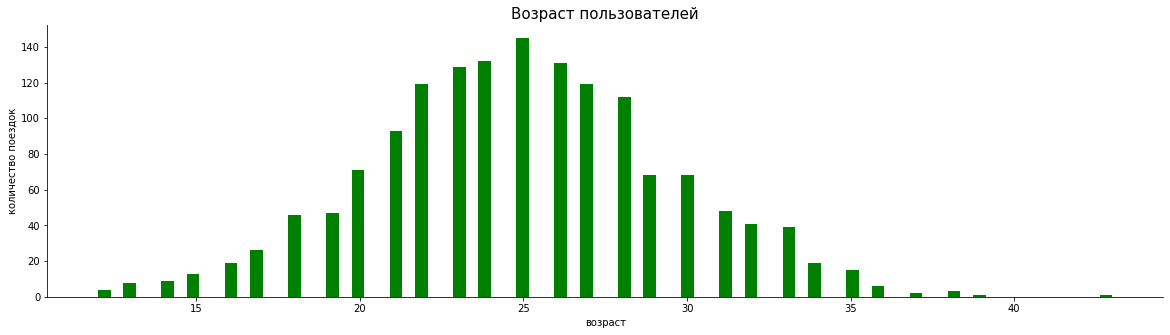

In [13]:
# строим гистограмму
users['age'].hist(bins=80, color='green', figsize=(20,5))

# установка заголовка графика
plt.title('Возраст пользователей', fontsize=15)

# добавление подписи осей
plt.ylabel('количество поездок')
plt.xlabel('возраст')

# уберем рамку
for pos in ['right', 'top']: 
    plt.gca().spines[pos].set_visible(False)

# убираем сетку
plt.grid(False)

# показ гистограммы
plt.show()

In [14]:
# описание данных
users['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

Чаще всего сервисом пользуются жители в возрасте 25 лет, минимальный возраст пользователей составил 12 лет, максимальный 43 года. Учитывая первый и третий квартиль можно сделать вывод, что сервисом в основном пользуются жители в возрасте от 22 до 28 лет. 

#### Расстояние, которое пользователь преодолел за одну поездку

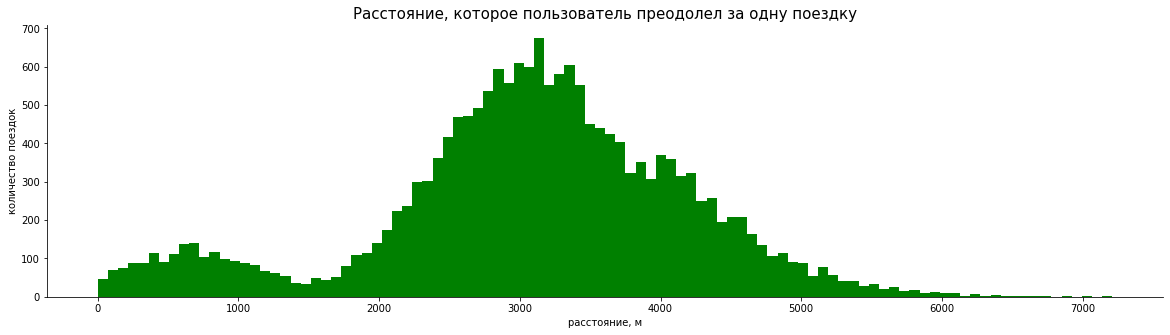

In [15]:
# строим гистограмму
rides['distance'].hist(bins=100, color='green', figsize=(20,5))

# установка заголовка графика
plt.title('Расстояние, которое пользователь преодолел за одну поездку', fontsize=15)

# добавление подписи осей
plt.ylabel('количество поездок')
plt.xlabel('расстояние, м')

# уберем рамку
for pos in ['right', 'top']: 
    plt.gca().spines[pos].set_visible(False)

# убираем сетку
plt.grid(False)

# показ гистограммы
plt.show()

In [16]:
# посмотрим минмальное, максимальное и медианное расстояние
rides['distance'].agg(['max', 'median', 'min']).round()

max       7211.0
median    3134.0
min          1.0
Name: distance, dtype: float64

Так как на графике расположенно два пика, учитываем вместо среднего значения медианное. Чаще всего пользователи проезжают в пределах 3 км, максимальное рассотяние - 7 км, минимальное - 1 м.

#### Продолжительность поездок

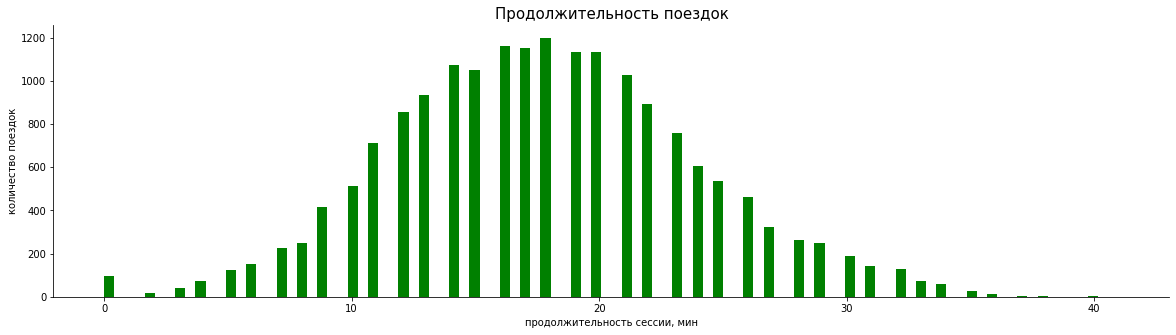

In [17]:
# строим гистограмму
rides['duration'].round().hist(bins=100, color='green', figsize=(20,5))

# установка заголовка графика
plt.title('Продолжительность поездок', fontsize=15)

# добавление подписи осей
plt.ylabel('количество поездок')
plt.xlabel('продолжительность сессии, мин')

# уберем рамку
for pos in ['right', 'top']: 
    plt.gca().spines[pos].set_visible(False)

# убираем сетку
plt.grid(False)

# показ гистограммы
plt.show()

In [18]:
# посмотрим минмальное, максимальное и медианное время
rides['duration'].agg(['max', 'mean', 'min']).round()

max     41.0
mean    18.0
min      0.0
Name: duration, dtype: float64

In [19]:
# посмотрим сколько поездок менее 1 минуты
rides.query('duration < 1')

,user_id,distance,duration,date
6531,701,4196.45,0.5,2021-08-31
6570,704,4830.82,0.5,2021-10-14
6680,712,4684.00,0.5,2021-03-04
6695,713,5215.64,0.5,2021-02-25
6768,718,5197.44,0.5,2021-02-11
...,...,...,...,...
17004,1460,5531.34,0.5,2021-01-19
17242,1477,6724.93,0.5,2021-01-12
17314,1483,4445.48,0.5,2021-03-06
17505,1496,5722.55,0.5,2021-02-14


Гистограмма показывает нормальное распределение без пиков, значит будем учитывать среднюю продолжительность поездки. Пользователи в среднем тратят на одну поездку 18 минут. Максимальная поездка была 41 минуту. Минимальное значение выглядит как аномальное. Вывод значений меньше 1 минуты показал, что пользователи тратят одинаковое время на поездку 30 секунд, при этом расстояние, которое они преодолевают невозможно за такой короткий промежуток времени. Есть предположение, что у самокатов произошел технический сбой в программе, либо ошибка выгрузки данных. 

### Объединение данных

#### Объединение всех датафреймов методом merge():

In [20]:
# исходный размер users
users.shape

(1534, 5)

In [21]:
# исходный размер rides
rides.shape

(18068, 4)

In [22]:
# исходный размер subscriptions
subscriptions.shape

(2, 4)

In [23]:
data = pd.merge(users, rides, how='outer')
total_data = pd.merge(data, subscriptions, how='outer')

In [24]:
total_data

,user_id,name,age,city,subscription_type,distance,duration,date,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.92,25.599769,2021-01-01,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.59,15.816871,2021-01-18,6,0,199
2,1,Кира,22,Тюмень,ultra,754.16,6.232113,2021-04-20,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.78,18.511000,2021-08-11,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.69,26.265803,2021-08-28,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.10,19.822962,2021-11-04,8,50,0
18064,1534,Альберт,25,Краснодар,free,2840.42,21.409799,2021-11-16,8,50,0
18065,1534,Альберт,25,Краснодар,free,3826.19,18.435051,2021-11-18,8,50,0
18066,1534,Альберт,25,Краснодар,free,2902.31,16.674362,2021-11-27,8,50,0


In [25]:
# смотрим размер таблицы после объединения

total_data.shape

(18068, 11)

In [26]:
# проверим количество уникальных пользователей после объединения

len(total_data['user_id'].unique())

1534

In [27]:
# проверим на наличие пропусков после объединения

total_data.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
distance             0
duration             0
date                 0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

После объединения количество строк в total_data совпало с исходным количеством строк в rides. Количество уникальных пользователей не изменилось. Пропуски после объединения не обнаружены.

#### Датафрейм с данными о пользователях без подписки:

In [28]:
sub_free = total_data.query('subscription_type == "free"')
sub_free

,user_id,name,age,city,subscription_type,distance,duration,date,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.69,14.944286,2021-01-02,8,50,0
6501,700,Айдар,22,Омск,free,846.93,16.234663,2021-02-01,8,50,0
6502,700,Айдар,22,Омск,free,4004.43,20.016628,2021-02-04,8,50,0
6503,700,Айдар,22,Омск,free,1205.91,9.782872,2021-02-10,8,50,0
6504,700,Айдар,22,Омск,free,3047.38,17.427673,2021-02-14,8,50,0
...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.10,19.822962,2021-11-04,8,50,0
18064,1534,Альберт,25,Краснодар,free,2840.42,21.409799,2021-11-16,8,50,0
18065,1534,Альберт,25,Краснодар,free,3826.19,18.435051,2021-11-18,8,50,0
18066,1534,Альберт,25,Краснодар,free,2902.31,16.674362,2021-11-27,8,50,0


#### Датафрейм с данными о пользователях с подпиской:

In [29]:
sub_ultra = total_data.query('subscription_type == "ultra"')
sub_ultra

,user_id,name,age,city,subscription_type,distance,duration,date,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.92,25.599769,2021-01-01,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.59,15.816871,2021-01-18,6,0,199
2,1,Кира,22,Тюмень,ultra,754.16,6.232113,2021-04-20,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.78,18.511000,2021-08-11,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.69,26.265803,2021-08-28,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...
6495,699,Оксана,22,Москва,ultra,3973.05,24.671163,2021-08-29,6,0,199
6496,699,Оксана,22,Москва,ultra,3288.70,15.892886,2021-09-12,6,0,199
6497,699,Оксана,22,Москва,ultra,3076.16,14.389525,2021-09-26,6,0,199
6498,699,Оксана,22,Москва,ultra,4707.85,15.839579,2021-10-17,6,0,199


#### Расстояние и время поездок для пользователей с подпиской и без:

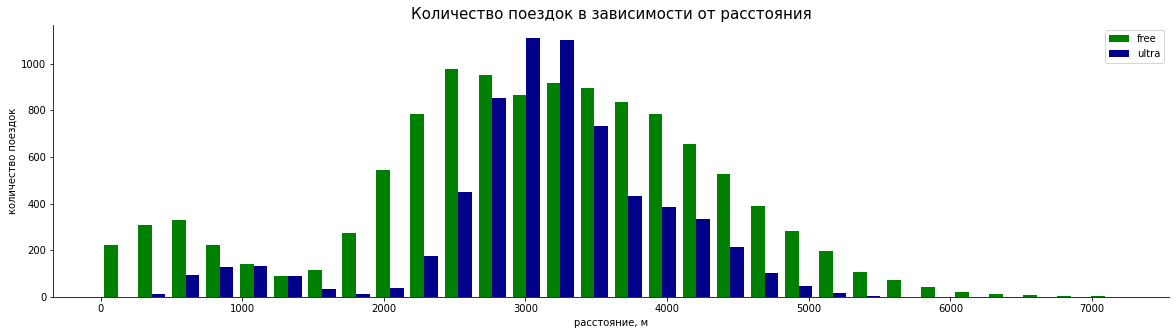

In [30]:
# зададим размер графика
plt.figure(figsize=(20, 5))

# строим гистограмму
plt.hist([sub_free['distance'], sub_ultra['distance']], bins=30, label=['free', 'ultra'], color=['green', 'darkblue'])

# установка заголовка графика
plt.title('Количество поездок в зависимости от расстояния', fontsize=15)

# место расположение легенды
plt.legend(loc='upper right')

# добавление подписей оси у
plt.xlabel('расстояние, м')
plt.ylabel('количество поездок')

# уберем рамку
for pos in ['right', 'top']: 
    plt.gca().spines[pos].set_visible(False)

# показ гистограммы
plt.show()

Описание столбцов датафреймов с указанием расстояния, в зависимости от наличия подписки:

In [31]:
# описание данных столбца с расстоянием без подписки
sub_free['distance'].describe().round(2)

count    11568.00
mean      3045.50
std       1246.17
min          0.86
25%       2366.56
50%       3114.65
75%       3905.70
max       7211.01
Name: distance, dtype: float64

In [32]:
# описание данных столбца с расстоянием при наличии подписки
sub_ultra['distance'].describe().round(2)

count    6500.00
mean     3115.45
std       836.90
min       244.21
25%      2785.45
50%      3148.64
75%      3560.58
max      5699.77
Name: distance, dtype: float64

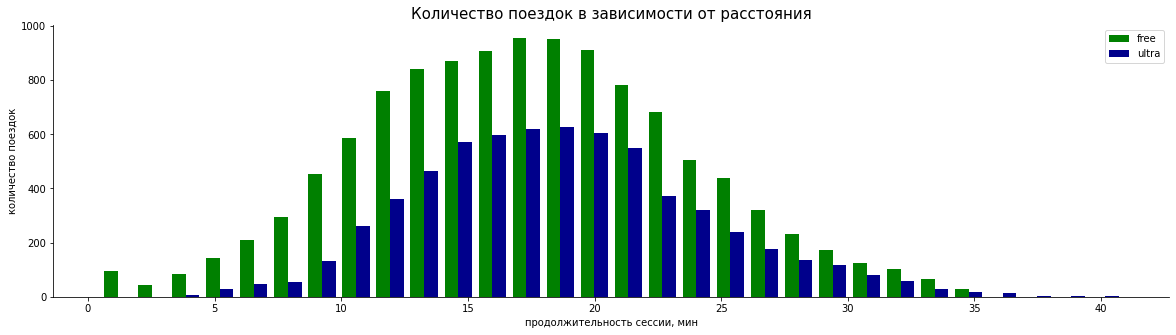

In [33]:
# зададим размер графика
plt.figure(figsize=(20, 5))

# строим гистограмму
plt.hist([sub_free['duration'], sub_ultra['duration']], bins=30, label=['free', 'ultra'], color=['green', 'darkblue'])

# установка заголовка графика
plt.title('Количество поездок в зависимости от расстояния', fontsize=15)

# место расположение легенды
plt.legend(loc='upper right')

# добавление подписей оси у
plt.xlabel('продолжительность сессии, мин')
plt.ylabel('количество поездок')

# уберем рамку
for pos in ['right', 'top']: 
    plt.gca().spines[pos].set_visible(False)
    
# показ гистограммы
plt.show()

Описание столбцов датафреймов с указанием продолжительности сессии, в зависимости от наличия подписки:

In [34]:
# описание данных столбца со временем без подписки
sub_free['duration'].describe().round(1)

count    11568.0
mean        17.4
std          6.3
min          0.5
25%         13.0
50%         17.3
75%         21.6
max         34.9
Name: duration, dtype: float64

In [35]:
# описание данных столбца со временем при наличии подписки
sub_ultra['duration'].describe().round(1)

count    6500.0
mean       18.5
std         5.6
min         3.8
25%        14.5
50%        18.2
75%        21.9
max        40.8
Name: duration, dtype: float64

В результате объеденения данных о пользователях, поездках и подписках в один датафрейм, созданы два датафрейма с данными о пользователях с подпиской и без нее.
По данным визуализации и описания этих датафреймов видно, что:
- среднее и медианное расстояние и время поездки выше у пользователей с подпиской;
- максимальное значение расстояния выше у пользователей без подписки;
- максимальное время поездки выше у пользователей с подпиской.


### Подсчёт выручки

#### Расчет суммарного расстояния, количества поездок и суммарного времени для каждого пользователя за каждый месяц

In [36]:
# каждое значение из столбцов округляем с помощью "потолка"
total_data['duration'] = np.ceil(total_data['duration']).astype(int)

In [37]:
# так как в данных указан только один год, оставим только месяцы
# и переименуем столбец 'date' в 'month'
total_data['date'] = pd.DatetimeIndex(total_data['date']).month
total_data.rename(columns = {'date' : 'month'}, inplace = True) 

In [38]:
# создание сводной таблицы
revenue = pd.pivot_table(total_data,
    index = ['user_id', 'month'],
    values = ['distance', 'duration','start_ride_price', 'minute_price', 'subscription_fee', 'subscription_type'],
    aggfunc = {'distance': {'count', 'sum'}, 
               'duration' : 'sum',
               'start_ride_price': 'mean',
               'minute_price': 'mean',
               'subscription_fee': 'mean',
               'subscription_type': 'min'})

In [39]:
# переименуем столбцы
revenue.columns = [
    'tips', 'distance',
    'duration',
    'minute_price',
    'start_ride_price',
    'subscription_fee',
    'subscription_type'
]

In [40]:
revenue

tips  distance  duration  minute_price  start_ride_price  \
user_id month                                                             
1       1         2   7027.51        42             6                 0   
        4         1    754.16         7             6                 0   
        8         2   6723.47        46             6                 0   
        10        2   5809.91        32             6                 0   
        11        3   7003.50        56             6                 0   
...             ...       ...       ...           ...               ...   
1534    6         2   3409.47        26             8                50   
        8         2   7622.45        48             8                50   
        9         1   4928.17        23             8                50   
        11        4  13350.02        78             8                50   
        12        1   2371.71        16             8                50   

               subscription_fee subscription_type  
user_id month                                      
1       1                   199             ultra  
        4                   199             ultra  
        8                   199             ultra  
        10                  199             ultra  
        11                  199             ultra  
...                         ...               ...  
1534    6                     0              free  
        8                     0              free  
        9                     0              free  
        11                    0              free  
        12                    0              free  

[11331 rows x 7 columns]

#### Выручка помесячно

In [41]:
revenue['revenue_per_month'] = (
    revenue['start_ride_price'] * 
    revenue['tips'] + 
    revenue['minute_price'] * 
    revenue['duration'] + 
    revenue['subscription_fee'])

In [42]:
revenue

tips  distance  duration  minute_price  start_ride_price  \
user_id month                                                             
1       1         2   7027.51        42             6                 0   
        4         1    754.16         7             6                 0   
        8         2   6723.47        46             6                 0   
        10        2   5809.91        32             6                 0   
        11        3   7003.50        56             6                 0   
...             ...       ...       ...           ...               ...   
1534    6         2   3409.47        26             8                50   
        8         2   7622.45        48             8                50   
        9         1   4928.17        23             8                50   
        11        4  13350.02        78             8                50   
        12        1   2371.71        16             8                50   

               subscription_fee subscription_type  revenue_per_month  
user_id month                                                         
1       1                   199             ultra                451  
        4                   199             ultra                241  
        8                   199             ultra                475  
        10                  199             ultra                391  
        11                  199             ultra                535  
...                         ...               ...                ...  
1534    6                     0              free                308  
        8                     0              free                484  
        9                     0              free                234  
        11                    0              free                824  
        12                    0              free                178  

[11331 rows x 8 columns]

На основании общего датафрейма total_data, создан новый датафрейм revenue c расчетом суммарного расстояния, количества поездок и суммарного времени, а также выручкой для каждого пользователя за каждый месяц.

### Проверка гипотез

**_Гипотеза 1:_** _Тратят ли пользователи с подпиской больше времени на поездки?_

**Н0:** Средняя продолжительность поездок с подпиской ‘ultra’ и ‘free’ равна.

**Н1:** Средняя продолжительность поездок с подпиской ‘ultra’ больше, чем с подпиской ‘free’.

In [43]:
# время поездки пользователей с подпиской
time_ultra = sub_ultra['duration']

# время поездки пользователей без подписки
time_free = sub_free['duration']

alpha = 0.05 # уровень статистической значимости

# проводим ttest для двух выборок, в качестве альтернативной используем одностороннюю гипотезу «больше»
results = st.ttest_ind(time_ultra, time_free, alternative='greater')

# вывод р-значения
print('р-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

р-значение: 1.2804098316645618e-34
Отвергаем нулевую гипотезу


Нет, пользователи с подпиской не тратят больше времени на поездки.

**_Гипотеза 2:_** _Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 м?_

**Н0:** Среднее расстояние поездок с использованием подписки ‘ultra’ равно оптимальному расстоянию в 3130 метров.


**Н1:** Среднее расстояние поездок с использованием подписки ‘ultra’ более 3130 метров.

In [44]:
# расстояние поездки пользователей с подпиской
distance_ultra = total_data.loc[total_data.subscription_type == 'ultra', 'distance']

# столько пользователи с подпиской проезжают за одну поездку
interested_value = 3130

# уровень статистической значимости
alpha = 0.05 

# проводим ttest для двух выборок, в качестве альтернативной используем одностороннюю гипотезу
results = st.ttest_1samp(distance_ultra, interested_value, alternative='greater')

# вывод р-значения
print('р-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

р-значение: 0.9195362605842414
Не получилось отвергнуть нулевую гипотезу


Да, среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 м.

**_Гипотеза 3:_** _Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?_

**Н0:** Средняя выручка от поездок с разной подпиской равна.

**Н1:** Средняя выручка от поездок с использованием подписки ‘ultra’ больше, чем выручка с ипользованием подписки ‘free’.

In [45]:
# помесячная выручка пользователей с подпиской
per_month_ultra = revenue.loc[revenue.subscription_fee == 199, 'revenue_per_month'] 

# помесячная выручка пользователей без подписки
per_month_free = revenue.loc[revenue.subscription_fee == 0, 'revenue_per_month'] 

alpha = 0.05 # уровень статистической значимости

# проводим ttest для двух выборок, в качестве альтернативной используем одностороннюю гипотезу «больше»
results = st.ttest_ind(per_month_ultra, per_month_free, alternative='greater')

# вывод р-значения
print('р-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

р-значение: 1.8850394384715216e-31
Отвергаем нулевую гипотезу


Помесячная выручка от пользователей с подпиской по месяцам меньше, чем выручка от пользователей без подписки.

**_Гипотеза 4:_** _Техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?_

О равенстве среднего значения генеральной совокупности до и после изменения используется метод scipy.stats.ttest_rel, аргументы которого - наборы данных (парные выборки до и после изменения). Используем односторонний тест,  альтернативная гипотеза которого будет утверждать, что количество обращений после обновления меньше, чем до обновления (alternative='less'). 

### Распределения

**Задача 1**

Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. 
Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

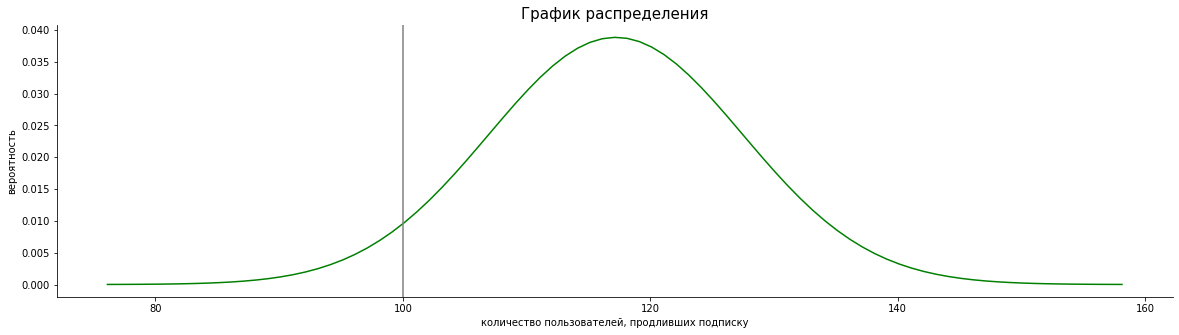

Для выполнения плана на 95% необходимо минимальное количество промокодов равное 1172


In [46]:
# параметры биномиального распределения
n = 1000
p = 0.1
k = 100
binom_cdf = 0.05

while binom_cdf < binom.cdf(k, n, p):
    n += 1

# зададим мат.ожидание и ст.отклонение нормального распределения равными
# мат.ожиданию и ст.отклонению биномиального распределения
mu = n * p
sigma = sqrt(n * p * (1 - p))

# Построение графика распределения
arange = np.arange((mu - 4 * sigma),(mu + 4 * sigma),1)
plt.figure(figsize=(20, 5))
plt.plot(arange, st.norm.pdf(arange, mu, sigma), 'b-', color='green')
plt.axvline(x=k, color='gray')
plt.title('График распределения', fontsize=15)
plt.xlabel('количество пользователей, продливших подписку')
plt.ylabel('вероятность')
for pos in ['right', 'top']: 
    plt.gca().spines[pos].set_visible(False)
plt.show()

print('Для выполнения плана на 95% необходимо минимальное количество промокодов равное', n)

**Задача 2**

Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

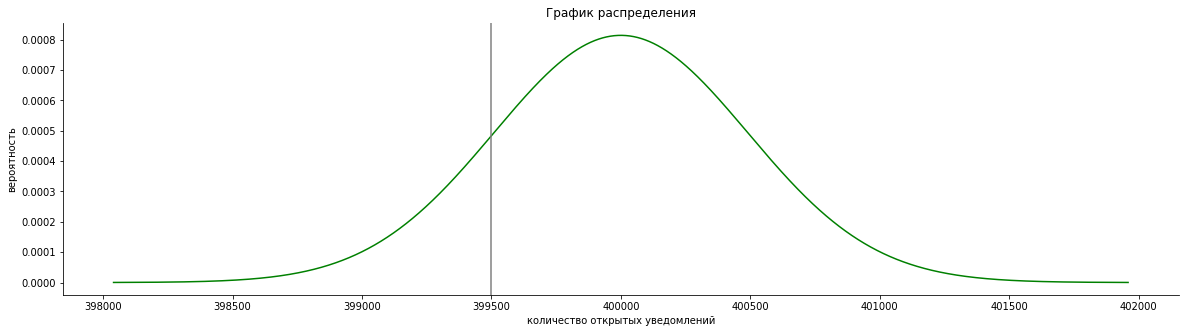

Вероятность открытия уведомлений не более 399,5 тыс. пользователями: 15.37 %


In [47]:
# параметры биномиального распределения
n = 1000000  
p = 0.4 

# параметры нормального распределения
mu = n * p  
sigma = sqrt(n * p * (1 - p)) 

distr = st.norm(mu, sigma) # нормальное распределение

result = distr.cdf(399500) # вероятность левого "хвоста"

# Построение графика распределения
arange = np.arange((mu - 4 * sigma),(mu + 4 * sigma),1)
plt.figure(figsize=(20, 5))
plt.plot(arange, st.norm.pdf(arange, mu, sigma), 'b-', color='green')
plt.axvline(x=399500, color='gray')
plt.title('График распределения')
plt.xlabel('количество открытых уведомлений')
plt.ylabel('вероятность')
for pos in ['right', 'top']: 
    plt.gca().spines[pos].set_visible(False)
plt.show()

print('Вероятность открытия уведомлений не более 399,5 тыс. пользователями:', (result * 100).round(2),'%')

### Общий вывод

Во время предобработки данных:
- пропущенные значения в столбцах всех таблиц не выявлены;  
- в столбце 'date' датафрейма rides изменим тип данных на datetime;
- в датафрейме users удалены дубликаты методом drop_duplicates().


Исследовательский анализ показал, что чаще всего сервисом GoFast пользуются:
- жители города Пятигорск;
- без подписки, но существенной разницы между наличием подписки нет;
- в возрасте около 25 лет, при этом минимальный возраст составил 12 лет, максимальный 43 года;
- в среднем проезжающих в пределах 3 км за 18 минут за одну поездку.
Максимальная поездка судя по данным составила 41 минуту, а минимальное значение выглядит как аномальное. Вывод значений меньше 1 минуты показал, что пользователи тратят одинаковое время на поездку 30 секунд, при этом расстояние, которое они преодолевают невозможно за такой короткий промежуток времени. Есть предположение, что у самокатов произошел технический сбой в программе, либо ошибка выгрузки данных.


В результате объеденения данных о пользователях, поездках и подписках в один датафрейм, созданы два датафрейма с данными о пользователях с подпиской и без нее. По данным визуализации и описания этих датафреймов видно, что:
- среднее и медианное расстояние и время поездки выше у пользователей с подпиской;
- максимальное значение расстояния выше у пользователей без подписки;
- максимальное время поездки выше у пользователей с подпиской.


На основании объединения данных, создан дополнительный столбец с помесячной выручкой по каждому пользователю.


На этапе проверки гипотез установлено:
- пользователи с подпиской не тратят больше времени на поездки;
- среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 м;
- помесячная выручка от пользователей с подпиской по месяцам меньше, чем выручка от пользователей без подписки;
- в дальнейшем при необходимости отрабатывать гипотезу по файлу, который содержит данные до и после изменения использовать метод scipy.stats.ttest_rel.

Задачи отдела маркетинга:
1. Чтобы отделу маркетинга провести акцию и достичь цели по привлечению определённого количества пользователей (выполнить план минимум на 95%), которые продлят подписку, потребуется выдать минимум 1172 промокода.
2. Вероятность открытия уведомлений, разосланных отделом маретинга, не более 399,5 тыс. пользователями составляет 15.37 %, слишком мала, возможно стоит пересмотреть изначальные условия.

**Рекомендации:** Пользователи с подпиской представляют собой более привлекательных клиентов для сервиса аренды самокатов, поэтому рекомендуется предпринять действия для перевода клиентов на подписку. Обратить внимание на продолжительность сессии меньше 1 минуты, тк есть предположение, что у самокатов произошел технический сбой в программе, либо ошибка выгрузки данных.